In [ ]:
!pip install pytesseract
!pip install pdf2image
!pip install easyocr
!apt-get install poppler-utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 27.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 1s (254 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking po

In [ ]:
import cv2
import numpy as np
import pytesseract
import pandas as pd
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import os
import easyocr as ocr

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"

pdf_file = "Tabla9.pdf"
pages = convert_from_path(pdf_file, dpi=150)

dataframes = []

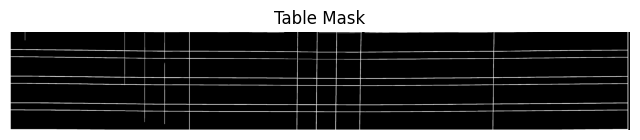

In [ ]:
img = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)[1]

kernel_h = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 1))
kernel_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))

horiz = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_h)
vert = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_v)

table_mask = horiz + vert

kernel_dilate = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
table_mask = cv2.dilate(table_mask, kernel_dilate, iterations=1)

ys, xs = np.where(table_mask > 0)
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()
cv2.rectangle(table_mask, (x_min, y_min), (x_max, y_max), color=255, thickness=5)

contours, _ = cv2.findContours(table_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(8, 6))
plt.imshow(table_mask, cmap='gray')
plt.title("Table Mask")
plt.axis('off')
plt.show()

In [ ]:
output_dir = "temp"
os.makedirs(output_dir, exist_ok=True)

min_h = 80
min_w = 20
max_h = 1500
max_w = 1500
padding = 5
ignore_left = 50

filtered_cells = []
for x, y, w, h in [cv2.boundingRect(cnt) for cnt in contours]:
    if x >= ignore_left and w >= min_w and h >= min_h and w <= max_w and h <= max_h:
        filtered_cells.append((x, y, w, h))

merged_cells = []
for x, y, w, h in filtered_cells:
    merged = False
    for i, (mx, my, mw, mh) in enumerate(merged_cells):
        if (abs(x - mx) < 10 and abs(y - my) < 10) or (abs(x+w - (mx+mw)) < 10 and abs(y+h - (my+mh)) < 10):
            nx = min(x, mx)
            ny = min(y, my)
            nw = max(x+w, mx+mw) - nx
            nh = max(y+h, my+mh) - ny
            merged_cells[i] = (nx, ny, nw, nh)
            merged = True
            break
    if not merged:
        merged_cells.append((x, y, w, h))

merged_cells = sorted(merged_cells, key=lambda c: c[1])

idx = 1
while merged_cells:
    bx, by, bw, bh = merged_cells[0]
    line_y = by + bh/2

    current_row = []
    remaining = []

    for cell in merged_cells:
        x, y, w, h = cell
        top = y
        bottom = y + h

        if top <= line_y <= bottom:
            current_row.append(cell)
        else:
            remaining.append(cell)

    current_row = sorted(current_row, key=lambda c: c[0])

    for x, y, w, h in current_row:
        x1p = max(x - padding, 0)
        y1p = max(y - padding, 0)
        x2p = min(x + w + padding, img.shape[1])
        y2p = min(y + h + padding, img.shape[0])
        roi = img[y1p:y2p, x1p:x2p]
        filename = os.path.join(output_dir, f"cell_{idx:03d}.png")
        cv2.imwrite(filename, roi)
        idx += 1

    merged_cells = remaining

In [ ]:
input_dir = "temp"
output_dir = "temp_preprocessed"
os.makedirs(output_dir, exist_ok=True)

scale_factor = 3
padding = 5

image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".png")])

for idx, filename in enumerate(image_files, 1):
    filepath = os.path.join(input_dir, filename)
    img = cv2.imread(filepath)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (gray.shape[1]*scale_factor, gray.shape[0]*scale_factor), interpolation=cv2.INTER_CUBIC)
    gray = cv2.copyMakeBorder(gray, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=255)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    thresh = cv2.dilate(thresh, kernel, iterations=1)

    save_path = os.path.join(output_dir, filename)
    cv2.imwrite(save_path, thresh)
    os.remove(filepath)

    if idx % 10 == 0:
        print(f"PROCESSED {idx}/{len(image_files)}")

PROCESSED 10/27
PROCESSED 20/27


In [ ]:
input_dir = "temp_preprocessed"
num_cols = 10

reader = ocr.Reader(['en'], gpu=True)

image_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".png")])

rows = []
current_row = []

for idx, filename in enumerate(image_files, 1):
    filepath = os.path.join(input_dir, filename)
    img = cv2.imread(filepath)

    result = reader.readtext(img, detail=0, paragraph=False)
    text = " ".join(result).strip() if result else ""

    current_row.append(text)

    os.remove(filepath)

    if len(current_row) == num_cols:
        rows.append(current_row)
        current_row = []

if current_row:
    rows.append(current_row)

df = pd.DataFrame(rows)
df


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


,0,1,2,3,4,5,6,7,8,9
0,YESSICA JHOSELINE CAYLLANTE CHURQUI,21,08,2001,MARIA REYNA,20,11,2010,LEANDRO CAYLLANTE QUENTA AMALIA CHURQUI FERNANDEZ,JAVIER ORUANDO ARIZACA RAMIREZ SARA ISABEL GUT...
1,MARIA ISABEL CHAMBI ALIAGA,12,06,2004,SAN JOSE OBRERO,18,09,2021,JOSE ANTONIO CHAMBI ESPINAL JOVANA CECILIA ALI...,FIDEL MARQUEZ LLOJLLA ANA CRISTINA CHAMBI ESPINAL
2,PABLO ANDRES MENA MEJIA,17,06,2004,CRISTO REY,04,12,2004,GUSTAVO ISAAC MENA GUZMAN CLAUDIA CONCEPCION M...,ISAAC GUSTAVO MENA GUZMAN CLAUDIA CONCEPCION M...
3,NICOLE OCHOA MENDEZ,29,11,2003,SAN PEDRO DEU NUEVA PAZ,27,11,2004,OVIDIO DANNY OCHOA TERCEROS KATIA FABIOLA MEND...,MILENKA GABY MENDEZ BECERRA
4,WARA LIBERTAD CORDERO PEREZ,21,02,2007,NTRA.SRA.DEL ROSARIO,24,02,2008,VICTOR HUGO CORDERO PENARRIETA LIBERTAD TERESA...,GERMAN LEON AGUILAR SCARLY CONTRERAS MOLLO
5,ALAN ROMERO CABRERA SACA,20,02,2006,NTRA.SRA. DEL ROSARIO,24,09,2011,GERMAN CABRERA CORI NANCY SACA CALLISAYA,MAYLI LAURA CABRERA SACA
6,VICTOR OMAR CHAVEZ LIMA,06,03,2005,SANTO DOMINGO,04,03,2006,OMAR ERICK CHAVEZ SANCHEZ CELIA ROSSEMARY LIMA...,NICOLAS CHOQUE MACHACA
7,21,03,2004,NTRA. SRA. DEL ROSARIO,09,11,2013,HERNAN FELIPE QUISPE PAJA ANGELICA AIZA CENA,JUAN CARLOS ESCALANTE TAPIA MARIBEL TAPIA CORTEZ,QUESLY GERALDINE MAMANI LUQUE
8,16,08,2005,NTRA. SRA. DE POMPEYA,08,01,2006,EDWIN RENE MAMANI MARIA EUGENIA LUQUE,EDWIN RENE MAMANI CORONEL EUCENIA MARIA LUQUE ...,EILEEN KELLY QUISPE ARUQUIPA
9,12,09,2004,SANTO DOMINGO,13,12,2014,JOSE RAMIRO QUISPE QUISPE DELIA ARUQUIPA POMA,JOSE CARLOS ARUQUIPA GALVEZ,KARINA JISEL CHAVEZ LIMA


In [ ]:
num_cols = 10
pattern = ['L','N','N','N','L','N','N','N','L','L']

arr_flat = df.to_numpy().flatten()
arr_flat = [str(v).strip() for v in arr_flat]

new_rows = []

while len(arr_flat) >= num_cols:
    block = arr_flat[:num_cols]
    block_pattern = []
    for v in block:
        if v == 'nD':
            block_pattern.append('E')
        else:
            first_char = v[0] if v else ''
            if first_char.isalpha():
                block_pattern.append('L')
            elif first_char.isdigit():
                block_pattern.append('N')
            else:
                block_pattern.append('E')

    match = all(bp == p or bp == 'E' for bp, p in zip(block_pattern, pattern))

    if match:
        new_rows.append(block)
        arr_flat = arr_flat[num_cols:]
    else:
        arr_flat.insert(0, 'nD')

df_fixed = pd.DataFrame(new_rows, columns=[f"Col{i+1}" for i in range(num_cols)])
df_fixed

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10
0,nD,nD,nD,2007,NTRA. SRA. DEL ROSARIO,27,10,2007,RAMIRO CALLA APAZA MONICA PAUCARA MAMANI,VICTORIA CALLA APAZA
1,nD,nD,nD,17 04 2006,SAN JOSE OBRERO,18,09,2021,MIGUEL CHAMBILLA CHINO PAULA MAMANI QUISPE,MIGUEL CHAMBILLA CHINO ROSA MAMANI ACUNA
2,nD,nD,nD,09 2004,NTRA. SRA. DEL ROSARIO,30,09,2006,EDGAR QUISPE USNAYO ROXANA MAURA MAMANI TARQUI,LOURDES QUISPE USNAYO


In [ ]:
import shutil
import os

if os.path.exists('temp_preprocessed'):
    shutil.rmtree('temp_preprocessed')
    print('Folder temp_preprocessed and its contents deleted successfully.')
else:
    print('Folder temp_preprocessed does not exist.')

Folder temp_preprocessed and its contents deleted successfully.
